In [7]:
import numpy as np
import pandas as pd
import random
import matplotlib.gridspec as gsp
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sc
import scipy.stats as stats 
%config InlineBackend.figure_format = 'retina'
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:100% !important;}</style>"))  
from scipy.special import gamma, factorial,digamma
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import scipy.special as sp 
from scipy import integrate
from joblib import Parallel, delayed

import sys
sys.path.append(r'/Users/ys18223/Documents/GitHub/forecast_BiocomputeLab')

import forecast as fc
import forecast.inference as infer
import forecast.simulations as sim
import forecast.cheat_codes as cc

# Create instance of class Simulation

In [8]:
df=pd.read_csv('Taniguchi_data.csv')
print('The diversity of the library is: ',len(df))
Theta1=df.iloc[:,0].to_numpy() 
Theta2=10*df.iloc[:,1].to_numpy() #Fluorescence protein ratio
Diversity=len(df)
Fluorescence_max=10**5
Bins=8
Distribution='gamma'
N=1E6
Ratio_amplification=100
Budget_reads=1e7 
Bias_library=False
# Create an instance of class experiment
Simulation=fc.Simulation(Bins,Diversity,N,Budget_reads,Fluorescence_max,Distribution,Ratio_amplification,Theta1,Theta2,Bias_library)

The diversity of the library is:  1018


In [9]:
df.head()

,A_Protein,B_Protein
0,4.935,3.401
1,6.020,3.514
2,7.660,353.058
3,7.115,10.637
4,6.770,1.931


# Conduct inference

In [10]:
Sij,Nj=sim.Sorting_and_Sequencing(Simulation)
print(Nj)
Reads=np.sum(Sij,axis=0)
Sij=Sij.astype(int)
N=sum(Nj)
print(Sij[:10,:])
print('the number of effective cells is ',np.sum(Nj)/len(df))
Experiment=fc.Experiment(Bins,Diversity,Nj,Reads,Sij,Fluorescence_max,Distribution)

[104807.  86086. 201731. 283945. 202630.  84404.  28355.   5959.]
[[   0    0  732 8181  416    0    0    0]
 [   0    0  177 8136 1107    0    0    0]
 [   0    0    0    0    0    0 3755 5549]
 [   0    0    0  259 8881  375    0    0]
 [   0    0 1231 8829   19    0    0    0]
 [   0    0    0  435 9474  105    0    0]
 [   0    0    0 4433 6112    0    0    0]
 [   0    0    0 1047 8117    0    0    0]
 [   0    0    0    0  228 6817 2610    0]
 [8693 1116  470   16    0    0    0    0]]
the number of effective cells is  980.2721021611002


In [12]:
w=len(Sij)
p=infer.inference(0,w,Experiment) #inference results are stored in this matrix
#Add ground truth and basic statistics to compare 
p['Mean'],p['standard deviation']=cc.ab_to_ms(Theta1,Theta2)
p['mu_ML'],p['sigma_ML']=cc.ab_to_ms(p['a_MLE'],p['b_MLE'])
p['a'],p['b']=Theta1,Theta2
# p['mu_MOM'],p['sigma_MOM']=cc.ab_to_ms(p['a_MOM'],p['b_MOM'])

In [13]:
p.tail()

,a_MLE,b_MLE,a_std,b_std,mu_MOM,sigma_MOM,Inference_grade,Score,Mean,standard deviation,mu_ML,sigma_ML,a,b
1013,9.741271,389.992794,0.294386,10.365361,4345.068175,3010.958530,1.0,0.000000,3817.36170,1241.459469,3799.025432,1217.206861,9.455,403.74
1014,3.921056,21.741453,0.107943,0.690544,125.441834,75.016051,1.0,0.000000,87.25900,46.312269,85.249460,43.051680,3.550,24.58
1015,4.668954,13.633375,0.112197,0.336890,90.872857,69.123318,1.0,0.000000,63.24500,29.649713,63.653602,29.458673,4.550,13.90
1016,0.203263,27.143961,0.005663,1.022563,8.391749,17.204644,1.0,0.728963,5.50200,12.302846,5.517352,12.237761,0.200,27.51
1017,0.602943,28.056586,0.010630,0.676364,23.485105,34.623092,1.0,0.337173,16.99245,21.667981,16.916522,21.785772,0.615,27.63


In [14]:
p.sort_values('Mean',ascending=True)['mu_ML']#[:850]

341        0.514723
543        0.573787
250        0.814625
489        0.901647
243        0.859195
           ...     
856    26246.197132
356    28262.643639
146    27159.546438
740    29938.742501
423    34706.242442
Name: mu_ML, Length: 1018, dtype: float64

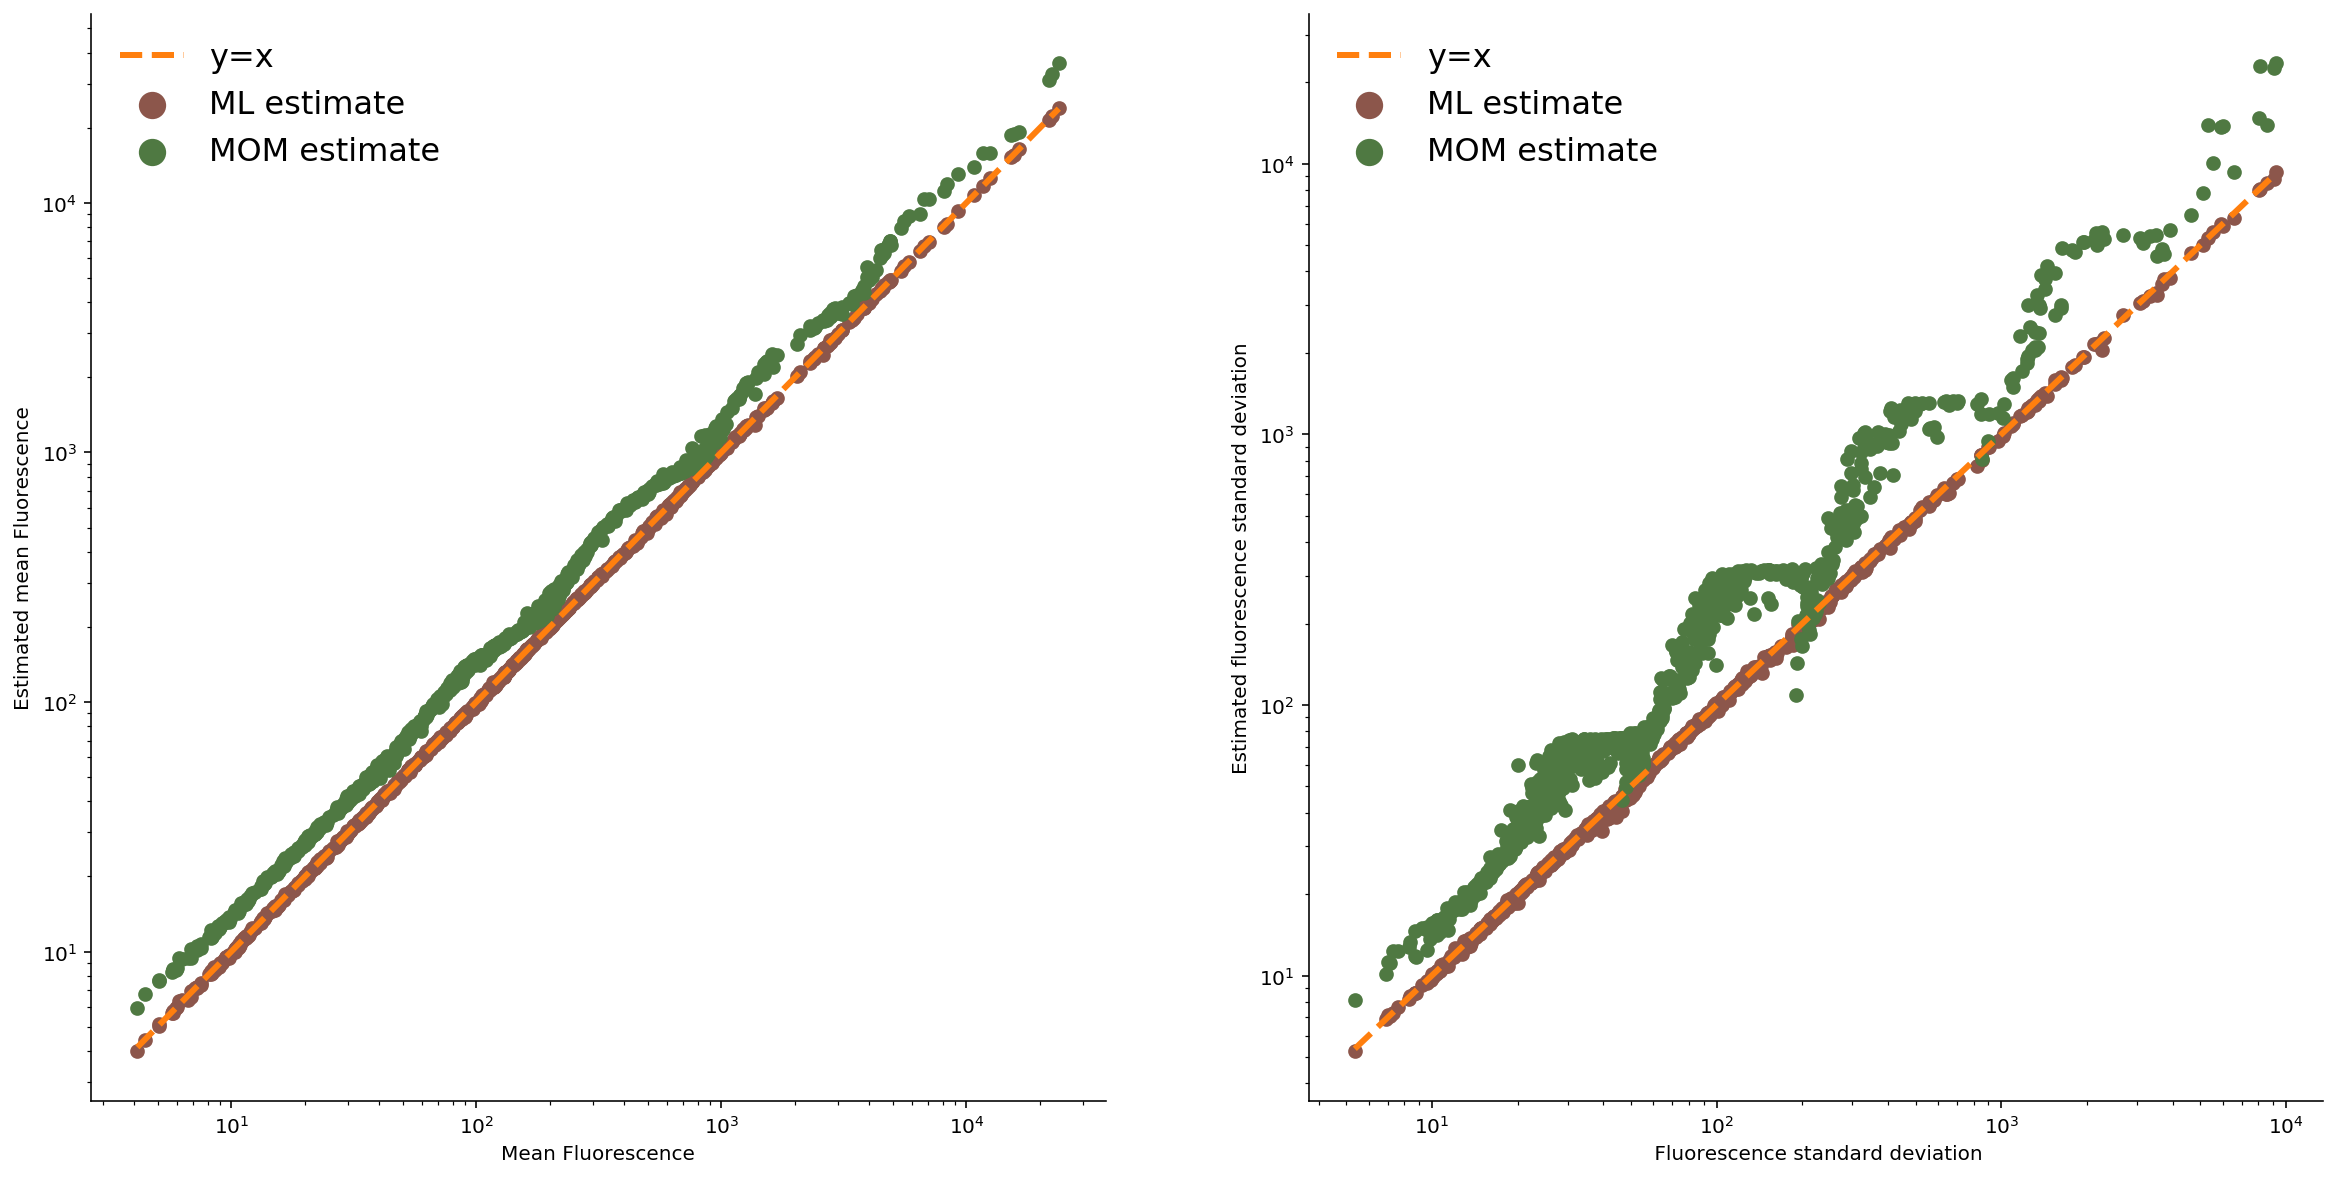

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,10))
#q.drop(q.index[[76,671]],inplace=True)

q=p[p['Score']<=0.7] #Keep constructs not on the border
q=q[q['Inference_grade']==1] #Keep contstructs with good shape
q=q[q['a_std']<q['a_MLE']]
q=q[q['b_std']<q['b_MLE']]

# X_mu=q.sort_values('Mean',ascending=True)['Mean'] 
# Y_mu=q.sort_values('Mean',ascending=True)['mu_ML'] 
# Z_mu=q.sort_values('Mean',ascending=True)['mu_MOM'] 
# X_sigma=q.sort_values('standard deviation',ascending=True)['standard deviation'] 
# Y_sigma=q.sort_values('standard deviation',ascending=True)['sigma_ML'] 
# Z_sigma=q.sort_values('standard deviation',ascending=True)['sigma_MOM'] 

X_mu=q.sort_values('Mean',ascending=True)['Mean']  
Y_mu=q.sort_values('Mean',ascending=True)['mu_ML']  
Z_mu=q.sort_values('Mean',ascending=True)['mu_MOM']  
X_sigma=q.sort_values('standard deviation',ascending=True)['standard deviation']   
Y_sigma=q.sort_values('standard deviation',ascending=True)['sigma_ML']   
Z_sigma=q.sort_values('standard deviation',ascending=True)['sigma_MOM']   

ax1.scatter(X_mu,Y_mu,s=40,c='tab:brown',label='ML estimate')
ax1.scatter(X_mu,Z_mu,s=40,c='#4f7942',label='MOM estimate')
ax1.plot(X_mu,X_mu,c='tab:orange',label='y=x',linewidth=3,linestyle='dashed')
ax1.legend()
ax1.set(xlabel='Mean Fluorescence', ylabel='Estimated mean Fluorescence')
#plt.title('')
ax1.legend(frameon=False,fontsize=16,markerscale=2)
ax1.set_yscale('log')
ax1.set_xscale('log')
ax2.scatter(X_sigma,Y_sigma,s=40,c='tab:brown',label='ML estimate')
ax2.scatter(X_sigma,Z_sigma,s=40,c='#4f7942',label='MOM estimate')
ax2.plot(X_sigma,X_sigma,c='tab:orange',label='y=x',linewidth=3,linestyle='dashed')
ax2.legend()
ax2.set(xlabel=' Fluorescence standard deviation', ylabel='Estimated fluorescence standard deviation')
ax2.legend(frameon=False,fontsize=16,markerscale=2)
ax2.set_yscale('log')
ax2.set_xscale('log')
sns.despine()

In [22]:
q.to_csv('values_inference.csv')

# Plotting Estimates/Ground Truth

3.784332579357084 23.132259387296415 2.9225632746997023 43.7863124119227


/opt/miniconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


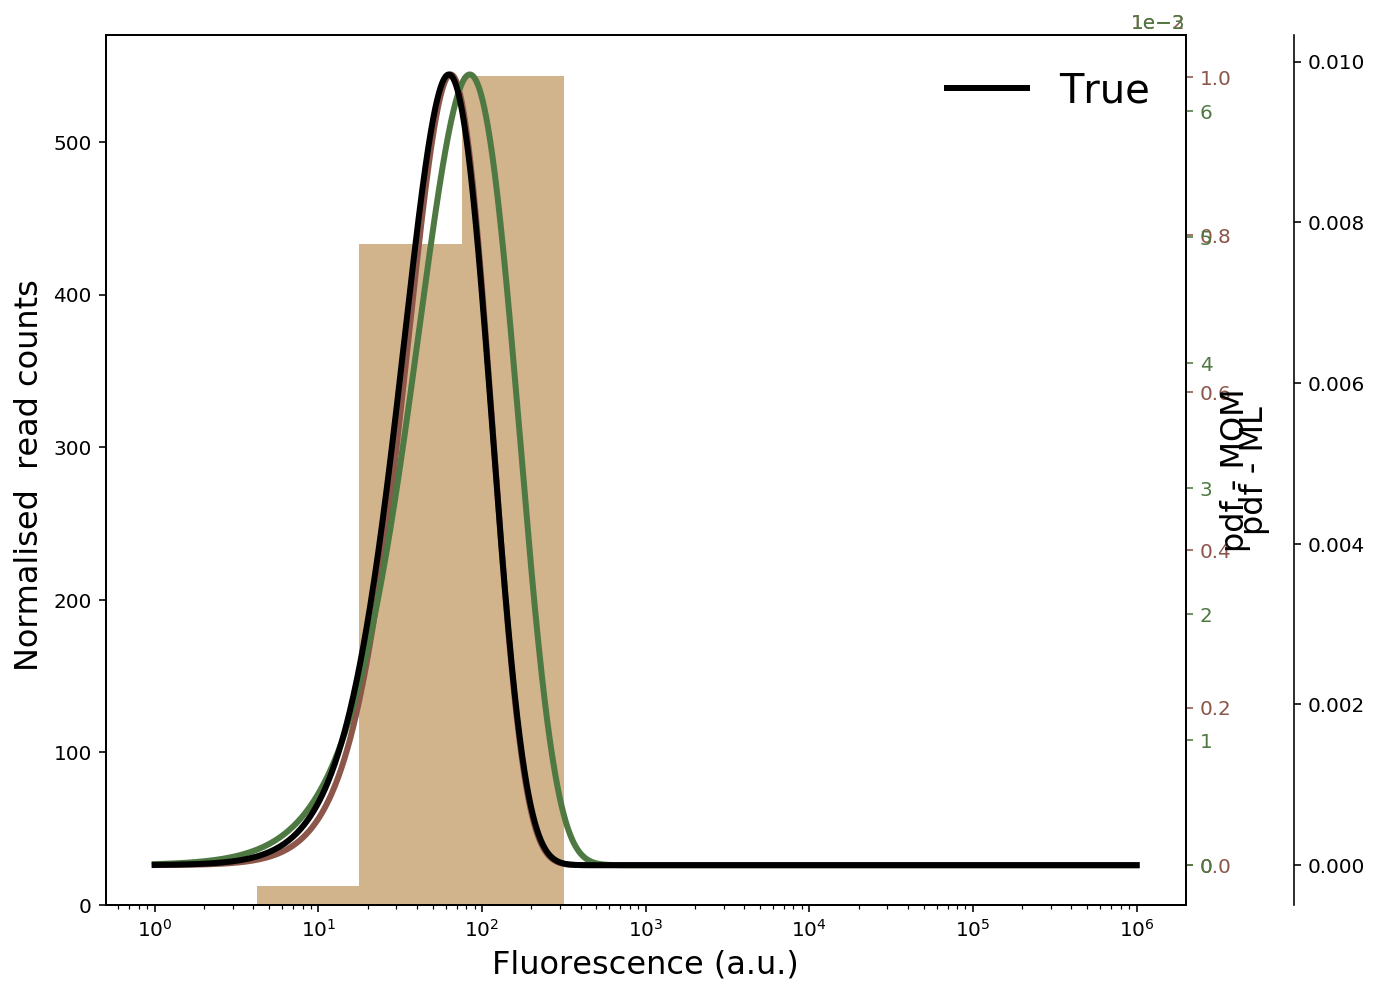

In [40]:
def data_transformation_bins(X):  #New representation of the data enabling the method of moments
    X=X.astype(int)
    T=np.repeat(Experiment.mean_assigned,X)
    return(T)

i=1014
x = np.linspace(1, 1e6, 5000000)
a =p.iloc[i,0]
b =p.iloc[i,1]
a2 =(p.iloc[i,4]**2)/(p.iloc[i,5]**2) #(10*p.iloc[i,4]/p.iloc[i,5])**2
b2= (p.iloc[i,5]**2)/p.iloc[i,4]

#Data
y_mle =stats.gamma.pdf(x, a, scale=b) # the normal pp
y_mom=stats.gamma.pdf(x, a2, scale=b2)
y=stats.gamma.pdf(x, p.iloc[i,12], scale=p.iloc[i,13])

#Graph
fig, ax = plt.subplots(figsize=(12,8))

# Twin the x-axis twice to make independent y-axes.
axes = [ax, ax.twinx(), ax.twinx(), ax.twinx()]

# Make some space on the right side for the extra y-axis.
fig.subplots_adjust(right=0.75)

# Move the last y-axis spine over to the right by 20% of the width of the axes
axes[-1].spines['right'].set_position(('axes', 1.1))

# To make the border of the right-most axis visible, we need to turn the frame
# on. This hides the other plots, however, so we need to turn its fill off.
axes[-1].set_frame_on(True)
axes[-1].patch.set_visible(False)
# And finally we get to plot things...
colors = ('tan','tab:brown', '#4f7942')
axes[0].hist(data_transformation_bins(Experiment.nijhat[i,:]),bins=np.logspace(0,np.log10(Fluorescence_max),Bins+1),zorder=0,color='tan',label='Read count')
axes[1].plot(x, y_mle, label='ML reconstruction',linewidth=3,zorder=5,color='tab:brown')
axes[2].plot(x, y_mom, label='MOM reconstruction',linewidth=3,zorder=3,c='#4f7942')
axes[3].plot(x, y, label='True',linewidth=3,zorder=3,c='black')

axes[0].set_ylabel('Normalised  read counts ',fontsize=16)
axes[1].set_ylabel('pdf - ML',fontsize=16)
axes[2].set_ylabel('pdf - MOM',fontsize=16)
plt.legend(frameon=False ,fontsize=20,markerscale=3)
axes[1].tick_params(axis='y', colors=colors[1])
axes[2].tick_params(axis='y', colors=colors[2])
axes[0].set_xlabel('Fluorescence (a.u.)',fontsize=16)
axes[1].ticklabel_format(axis="y",style="sci", scilimits=(0,0))
axes[2].ticklabel_format(axis="y",style="sci", scilimits=(0,0))
plt.xscale('log')
print(a,b,a2,b2)

In [ ]:
in black-Ground truth
in Green- MoM inference
in brown- ML inference